In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(dataset, time_steps=1):
    data_x, data_y = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        data_x.append(a)
        data_y.append(dataset[i + time_steps])
    return np.array(data_x), np.array(data_y)

## Bitcoin

In [ ]:
data = pd.read_csv('data/BTC.csv')

In [ ]:
data.describe()

In [ ]:
g = sns.lineplot(x = np.linspace(1,3049,3049), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,3049,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

In [ ]:
data_high = data["High"].to_numpy()
data_high = data_high[np.logical_not(np.isnan(data_high))]
data_high.shape

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))

data_normalized = scaler.fit_transform(data_high.reshape((-1, 1)))
data_normalized = np.reshape(data_normalized, (3048,))

In [ ]:
time_steps = 1

X, y = create_dataset(data_normalized, time_steps)

In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0: train_size, :], X[train_size: len(X), :]
y_train, y_test = y[0: train_size], y[train_size: len(y)]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape

In [ ]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(1, time_steps), dropout=0.2))

model.add(layers.Dense(1))

In [ ]:
loss = 'mean_squared_error'

opt = 'adam'

metrics = ['mean_squared_error']

filepath = "models/bitcoin_model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

model.compile(loss = loss, 
              optimizer = opt,
              metrics = metrics)

model.summary()

In [ ]:
batchsize = 32

epochs =  100

# Fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs = epochs, 
                    batch_size = batchsize,
                    validation_split = 0.2,
                    shuffle=False,
                    callbacks = callbacks_list)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
dataset = scaler.fit_transform(data_high.reshape((-1, 1)))

test_predict = model.predict(X_test)
train_predict = model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time_steps:len(train_predict)+time_steps, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:] = np.nan
test_plot[len(train_predict)+time_steps:len(dataset)-1] = test_predict

plt.plot(scaler.inverse_transform(data_normalized.reshape(-1, 1)))
plt.plot(train_plot)
plt.plot(test_plot)
plt.legend(['real', 'train', 'prediction'])
plt.show()

## Ethereum

In [10]:
data_eth = pd.read_csv('data/ETH.csv')

In [11]:
data_eth.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1.901000e+03
mean,1132.731411,1169.000127,1091.724040,1133.188078,1133.188078,1.282986e+10
std,1182.114851,1218.202714,1140.391476,1181.542070,1181.542070,1.075124e+10
min,84.279694,85.342743,82.829887,84.308296,84.308296,6.217330e+08
25%,211.552200,217.628021,207.109070,211.545380,211.545380,4.476532e+09
50%,524.038025,540.487000,504.237762,526.439026,526.439026,1.047685e+10
75%,1762.084839,1806.886475,1683.906616,1757.941772,1757.941772,1.810958e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


[Text(0, 0, '2017-11-09'),
 Text(200, 0, '2018-05-28'),
 Text(400, 0, '2018-12-14'),
 Text(600, 0, '2019-07-02'),
 Text(800, 0, '2020-01-18'),
 Text(1000, 0, '2020-08-05'),
 Text(1200, 0, '2021-02-21'),
 Text(1400, 0, '2021-09-09'),
 Text(1600, 0, '2022-03-28'),
 Text(1800, 0, '2022-10-14')]

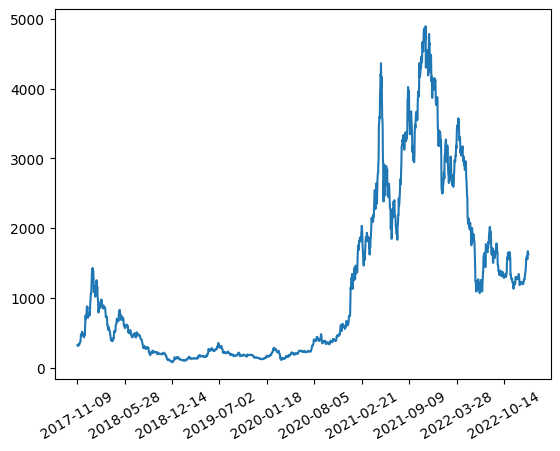

In [12]:
g = sns.lineplot(x = np.linspace(1,1902,1902), y = data_eth['High'].values.reshape(-1))
g.set(xticks=np.arange(0,1902,200))
g.set_xticklabels(rotation=30, labels = data_eth['Date'][0::200])

In [13]:
data_eth_high = data_eth["High"].to_numpy()
data_eth_high = data_eth_high[np.logical_not(np.isnan(data_eth_high))]
data_eth_high.shape

(1901,)

In [14]:
scaler = MinMaxScaler(feature_range = (0, 1))

data_eth_normalized = scaler.fit_transform(data_eth_high.reshape((-1, 1)))
data_eth_normalized = np.reshape(data_eth_normalized, (1901,))

In [15]:
time_steps = 1

X_eth, y_eth = create_dataset(data_eth_normalized, time_steps)

In [16]:
train_eth_size = int(len(X_eth) * 0.8)
test_eth_size = len(X_eth) - train_eth_size
X_eth_train, X_eth_test = X_eth[0: train_eth_size, :], X_eth[train_eth_size: len(X_eth), :]
y_eth_train, y_eth_test = y_eth[0: train_eth_size], y_eth[train_eth_size: len(y_eth)]

In [17]:
X_eth_train = np.reshape(X_eth_train, (X_eth_train.shape[0], 1, X_eth_train.shape[1]))
X_eth_test = np.reshape(X_eth_test, (X_eth_test.shape[0], 1, X_eth_test.shape[1]))

X_eth_train.shape

(1519, 1, 1)

In [18]:
model_ETH = Sequential()
model_ETH.add(layers.LSTM(64, input_shape=(1, time_steps), return_sequences=True, dropout=0.1))
model_ETH.add(layers.LSTM(128, input_shape=(1, time_steps), return_sequences=True, dropout=0.1))
model_ETH.add(layers.GRU(64, return_sequences=False, dropout=0.1))

model_ETH.add(layers.Dense(32, activation='relu'))
model_ETH.add(layers.Dense(1))

In [19]:
loss = 'mean_squared_error'

opt = 'adam'

metrics = ['mean_squared_error']

filepath = "models/eth_model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

model_ETH.compile(loss = loss, 
              optimizer = opt,
              metrics = metrics)

model_ETH.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 155,073
Trainable params: 155,073
Non-trainable params: 0
_________________________________________________________________


In [20]:
batchsize = 32

epochs =  100

# Fit model
history_ETH = model_ETH.fit(X_eth_train,
                            y_eth_train,
                            epochs = epochs, 
                            batch_size = batchsize,
                            validation_split = 0.2,
                            shuffle=False,
                            callbacks = callbacks_list)

Epoch 1/100
28/38 [=====================>........] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 1: mean_squared_error improved from inf to 0.00900, saving model to models\eth_model.hdf5
38/38 [==============================] - 6s 32ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.4071 - val_mean_squared_error: 0.4071
Epoch 2/100
30/38 [======================>.......] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 2: mean_squared_error improved from 0.00900 to 0.00853, saving model to models\eth_model.hdf5
38/38 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 3/100
30/38 [======================>.......] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3: mean_squared_error improved from 0.00853 to 0.00805, saving model to models\eth_model.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 

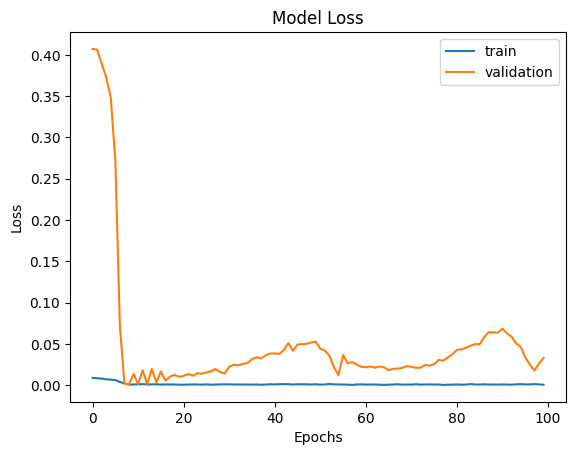

In [21]:
plt.plot(history_ETH.history['loss'])
plt.plot(history_ETH.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

48/48 [==============================] - 0s 2ms/step
Test Score: 351.45 RMSE


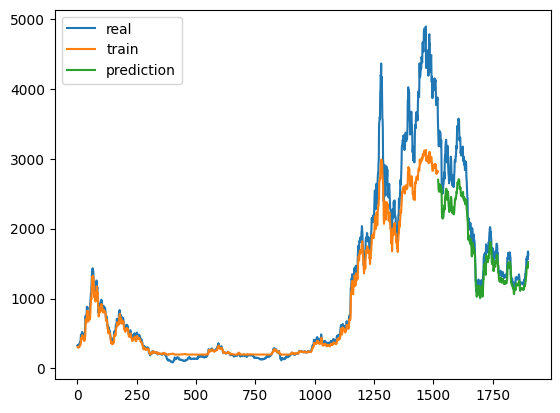

In [22]:
data_eth = scaler.fit_transform(data_eth_high.reshape((-1, 1)))

test_eth_predict = model_ETH.predict(X_eth_test)
train_eth_predict = model_ETH.predict(X_eth_train)

train_eth_predict = scaler.inverse_transform(train_eth_predict)
train_eth_Y = scaler.inverse_transform([y_eth_train])
test_eth_predict = scaler.inverse_transform(test_eth_predict)
y_eth_test = scaler.inverse_transform([y_eth_test])

test_eth_score = np.sqrt(mean_squared_error(y_eth_test[0], test_eth_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_eth_score))

train_eth_plot = np.empty_like(data_eth)
train_eth_plot[:, :] = np.nan
train_eth_plot[time_steps:len(train_eth_predict)+time_steps, :] = train_eth_predict

test_eth_plot = np.empty_like(data_eth)
test_eth_plot[:] = np.nan
test_eth_plot[len(train_eth_predict)+time_steps:len(data_eth)-1] = test_eth_predict

plt.plot(scaler.inverse_transform(data_eth_normalized.reshape(-1, 1)))
plt.plot(train_eth_plot)
plt.plot(test_eth_plot)
plt.legend(['real', 'train', 'prediction'])
plt.show()